# TAL aplicado al análisis del discurso de los medios de prensa 📰🤓🔥


### Cronograma

- Hito Unidad 2 (27 de octubre): Implementación y experimentos de varios modelos de clasificación

- Hito Proyecto (15 de diciembre): Evaluación y comparación de los modelos de los distintos equipos + integración de los mejores modelos en la arquitectura Sophia2.


## índex
1. [Importación del dataset](a)
2. [Balancear dataset](b)
3. [Inicialización del modelo spaCy y tokenización](c)
4. [Definición de la arquitectura CNN](d)
5. [Funciones para optimizar el modelo](e)
6. [Funciones para evaluar el modelo](f)
7. [Optimización del modelo](g)
8. [Evaluación del modelo](h)   
    8.1 [Matriz de confusión](k)


In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [ ]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install tqdm
#!pip install -U spacy
#!pip install torchtext
#!conda install pytorch-cpu torchvision-cpu -c pytorch
#!pip install imblearn

In [2]:
import time
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import re
import pandas as pd
import numpy as np
import random
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedShuffleSplit

# Plotting
import matplotlib.pyplot as plt
from tqdm import tqdm

# NLP
import spacy
import torch
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.legacy import data

# Reports
from sklearn.metrics import confusion_matrix, classification_report

# CNN
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


2021-12-16 06:58:38.629778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-16 06:58:38.629869: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 1. Importación del dataset

In [3]:
train = pd.read_csv("CNN_train.csv")
test = pd.read_csv("CNN_test.csv")
valid = pd.read_csv("CNN_valid.csv")

In [4]:
display(train['label'].value_counts())

política y conflictos         3927
catástrofes y accidentes      3927
cultura y arte                3927
salud                         3927
mundo                         3927
ciencia y tecnología          3927
economía                      3927
deporte                       3927
crimen, delitos y justicia    3927
ecología y planeta            3927
Name: label, dtype: int64

### 2. Balancear dataset
Realizaremos random undersampling

In [ ]:
valid, test, train = np.split(x_res.sample(frac=1), 
                              [int(.15*len(x_res)), int(.3*len(x_res))])

print("Largo dataset entrenamiento: ", len(train))
print("Largo dataset validación: ", len(valid))
print("Largo dataset test", len(test))

In [ ]:
train['label'].value_counts()

In [ ]:
undersample = RandomUnderSampler(random_state=0)
x_res,y_res = undersample.fit_resample(train,train['label'])
fig, ax = plt.subplots(figsize=(5,5),tight_layout=True)
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Undersampling")
plt.show()

In [ ]:
x_res.to_csv("CNN_train.csv", encoding="UTF-8",index=False)
valid.to_csv("CNN_valid.csv", encoding="UTF-8",index=False)
test.to_csv("CNN_test.csv", encoding="UTF-8",index=False)

### 3. Inicialización del modelo spaCy y tokenización

In [ ]:
#!python -m spacy download es_core_news_sm

In [5]:
spacy_es = spacy.load('es_core_news_sm')
def tokenize_es(sentence):
    return [tok.text for tok in spacy_es.tokenizer(sentence)]



TEXT = data.Field(tokenize=tokenize_es, batch_first = True)
LABEL = data.LabelField()
fields = [('content', TEXT),('label', LABEL)]

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = '.',
                                        train = 'CNN_train.csv',
                                        validation= 'CNN_valid.csv',
                                        test = 'CNN_test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

In [6]:
BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=lambda x:len(x.label),
    sort_within_batch=False)

cpu


### 4. Definición de la arquitectura CNN

In [7]:
#!wget http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz

In [8]:
MAX_VOCAB_SIZE = 50000

## TENER VECTORES EN ESPAÑOL
vec = torchtext.vocab.Vectors('glove-sbwc.i25.vec.gz', cache='.')
TEXT.build_vocab(train_data, vectors=vec, max_size = MAX_VOCAB_SIZE, unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [9]:
print(LABEL.vocab.stoi)

defaultdict(None, {'catástrofes y accidentes': 0, 'ciencia y tecnología': 1, 'crimen, delitos y justicia': 2, 'cultura y arte': 3, 'deporte': 4, 'ecología y planeta': 5, 'economía': 6, 'mundo': 7, 'política y conflictos': 8, 'salud': 9})


In [10]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
    
        super().__init__()
    
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        
        embedded = self.embedding(text)     
        embedded = embedded.unsqueeze(1)
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]    
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        return self.fc(cat)

In [11]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

OUTPUT_DIM

10

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,273,910 trainable parameters


In [13]:
pretrained_embeddings = TEXT.vocab.vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

### 5. Funciones para optimizar el modelo

In [14]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss() #MULTICLASS ---> en lugar de .BCEWithLogitsLoss() (Binary Cross Entropy)

model = model.to(device)
criterion = criterion.to(device)

In [15]:
def train(model, iterator, optimizer, criterion, divisor):
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch in tqdm(iterator, desc='train'):
        
        optimizer.zero_grad()
        predictions = model(batch.content)
        
        loss = criterion(predictions, batch.label)
        acc = categorical_accuracy(predictions, batch.label, divisor)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [16]:
def epoch_time(start_time, end_time):
    
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    return elapsed_mins, elapsed_secs

### 6. Funciones para evaluar el modelo

In [17]:
def categorical_accuracy(preds, y, divisor):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    
    return correct.sum() / divisor([y.shape[0]])

In [18]:
def evaluate(model, iterator, criterion, divisor):
    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in tqdm(iterator, desc='eval'):

            predictions = model(batch.content)
            loss = criterion(predictions, batch.label)
            acc = categorical_accuracy(predictions, batch.label, divisor)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### 7. Optimización del modelo

In [19]:
print("inicio optimización")

N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    divisor = torch.FloatTensor if str(device) == 'cpu' else torch.cuda.FloatTensor
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, divisor)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, divisor)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        name = './tematic-model-CNN'+'_ep'+str(epoch+1)+'.pt'
        torch.save({'epoca': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'Valid_loss': best_valid_loss}, name)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

inicio optimización


eval: 100%|███████████████████████████████████████████████████████| 267/267 [01:48<00:00,  2.47it/s]


Epoch: 01 | Epoch Time: 47m 16s
	Train Loss: 1.278 | Train Acc: 59.02%
	 Val. Loss: 0.959 |  Val. Acc: 68.79%


eval: 100%|███████████████████████████████████████████████████████| 267/267 [01:49<00:00,  2.44it/s]


Epoch: 02 | Epoch Time: 48m 23s
	Train Loss: 0.947 | Train Acc: 68.99%
	 Val. Loss: 0.852 |  Val. Acc: 71.21%


eval: 100%|███████████████████████████████████████████████████████| 267/267 [01:57<00:00,  2.28it/s]


Epoch: 03 | Epoch Time: 52m 9s
	Train Loss: 0.755 | Train Acc: 74.73%
	 Val. Loss: 0.813 |  Val. Acc: 72.59%


eval: 100%|███████████████████████████████████████████████████████| 267/267 [01:51<00:00,  2.39it/s]


Epoch: 04 | Epoch Time: 55m 29s
	Train Loss: 0.582 | Train Acc: 80.52%
	 Val. Loss: 0.837 |  Val. Acc: 72.33%


eval: 100%|███████████████████████████████████████████████████████| 267/267 [02:25<00:00,  1.84it/s]


Epoch: 05 | Epoch Time: 54m 59s
	Train Loss: 0.432 | Train Acc: 85.74%
	 Val. Loss: 0.901 |  Val. Acc: 72.40%


### 8. Evaluación del modelo

In [20]:
best_model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [21]:
pretrained_embeddings = TEXT.vocab.vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

best_model.embedding.weight.data.copy_(pretrained_embeddings)
best_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
best_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [22]:
name = './tematic-model-CNN'+'_ep'+str(1)+'.pt'
best_model.load_state_dict(torch.load(name, map_location=torch.device('cpu'))['model_state_dict'])

<All keys matched successfully>

In [23]:
test_loss, test_acc = evaluate(model, test_iterator, criterion, divisor)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

eval: 100%|███████████████████████████████████████████████████████| 267/267 [03:33<00:00,  1.25it/s]

Test Loss: 0.897 | Test Acc: 72.71%


In [24]:
prediction_test = []
labels_test=[]

for batch in tqdm(test_iterator, desc='predictions'):
    labels_test.append(batch.label.cpu().detach().numpy())
    predictions = best_model(batch.content.cpu()).squeeze(1)
    prediction_test.append(predictions.argmax(dim=1).detach().numpy())
        
y_true = np.concatenate(labels_test)
y_pred = np.concatenate(prediction_test)

predictions: 100%|████████████████████████████████████████████████| 267/267 [01:51<00:00,  2.40it/s]


#### 8.1 Matriz de confusión

              precision    recall  f1-score   support

           0      0.713     0.878     0.787       894
           1      0.512     0.488     0.500       845
           2      0.602     0.740     0.664       867
           3      0.877     0.915     0.895       857
           4      0.505     0.486     0.495       836
           5      0.883     0.914     0.899       852
           6      0.667     0.665     0.666       813
           7      0.407     0.206     0.273       861
           8      0.521     0.463     0.490       836
           9      0.704     0.801     0.749       873

    accuracy                          0.658      8534
   macro avg      0.639     0.656     0.642      8534
weighted avg      0.640     0.658     0.643      8534



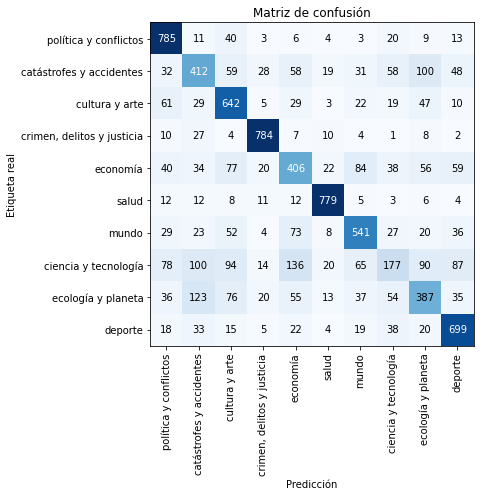

In [29]:
def plot_confusion_matrix(cm, labels, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(7, 7), tight_layout=True)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, "{:,}".format(cm[i, j]), 
                    horizontalalignment="center", verticalalignment="center",
                    color="white" if cm[i, j] > np.amax(cm)/2 else "black")
    ax.set_title("Matriz de confusión")
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation='vertical')
    plt.yticks(tick_marks, labels)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Predicción')

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, labels=list(test['label'].unique()))
print(classification_report(y_true, y_pred, digits=3))